## Observations and Insights 

Based on average final tumor volume both Capomulin and Ramicane appeared to be equally effective, but to be sure of this we would need to make sure the starting tumor volumes were equivalent.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
from pandas import DataFrame
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset, that rounds to 1dp.
trial_data = pd.merge(study_results, mouse_metadata, on='Mouse ID', how="outer").round(1)
trial_data.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,b128,5,45.7,0,Capomulin,Female,9,22
2,b128,10,43.3,0,Capomulin,Female,9,22
3,b128,15,43.8,0,Capomulin,Female,9,22
4,b128,20,42.7,0,Capomulin,Female,9,22


In [2]:
# Checking the number of mice.
total_mice = trial_data['Mouse ID'].nunique()
print(f'Before data cleansing, there are a total of: {total_mice} mice in the Pymaceutical SCC Tumor Growth Study')

Before data cleansing, there are a total of: 249 mice in the Pymaceutical SCC Tumor Growth Study


In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint.
# Specifically to the above ask - .value.counts() totals the instances in the 'Mouse ID' column. As we know each mouse should have 10 Timeframe increiments between
# 0 - 45, any Mouse ID's with a >10 count indicates duplicates. In this instance it's just Mouse ID: g898.
trial_data["Mouse ID"].value_counts().head()

g989    13
t718    10
n364    10
p136    10
b879    10
Name: Mouse ID, dtype: int64

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
duplicate_mouse_ID = trial_data.loc[trial_data["Mouse ID"] == 'g989']
duplicate_mouse_ID

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.0,0,Propriva,Female,21,26
861,g989,0,45.0,0,Propriva,Female,21,26
862,g989,5,48.8,0,Propriva,Female,21,26
863,g989,5,47.6,0,Propriva,Female,21,26
864,g989,10,51.7,0,Propriva,Female,21,26
865,g989,10,49.9,0,Propriva,Female,21,26
866,g989,15,51.3,1,Propriva,Female,21,26
867,g989,15,53.4,0,Propriva,Female,21,26
868,g989,20,55.3,1,Propriva,Female,21,26
869,g989,20,54.7,1,Propriva,Female,21,26


In [5]:
cleansed_trial_data = trial_data[trial_data["Mouse ID"] != 'g989']
cleansed_trial_data.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,b128,5,45.7,0,Capomulin,Female,9,22
2,b128,10,43.3,0,Capomulin,Female,9,22
3,b128,15,43.8,0,Capomulin,Female,9,22
4,b128,20,42.7,0,Capomulin,Female,9,22


In [6]:
# Checking the number of mice in the clean DataFrame.
new_mice_total = cleansed_trial_data["Mouse ID"].nunique()
print(f'After data cleansing, there are a total of: {new_mice_total} mice in the Pymaceutical SCC Tumor Growth Study')

After data cleansing, there are a total of: 248 mice in the Pymaceutical SCC Tumor Growth Study


## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# Accessing the three columns required for the statistical table from the Dataframe
tumor_volume = cleansed_trial_data.loc[: ,['Drug Regimen', 'Tumor Volume (mm3)']]
tumor_volume.head()

# Grouping and storing the mean, median, variance, standard deviation and SEM of the tumor_volumn_mm3, grouped by Drug and Timepoint 
tumor_volume.groupby(['Drug Regimen']).agg({"Tumor Volume (mm3)" :["mean", "median", "var", "std", "sem"]})

Tumor Volume (mm3)                                      
                           mean median        var       std       sem
Drug Regimen                                                         
Capomulin             40.678261  41.55  24.954809  4.995479  0.329392
Ceftamin              52.589326  51.80  39.254292  6.265325  0.469606
Infubinol             52.885955  51.80  43.074321  6.563103  0.491925
Ketapril              55.237766  53.70  68.553379  8.279697  0.603859
Naftisol              54.330108  52.50  66.178440  8.135013  0.596488
Placebo               54.032044  52.30  61.148079  7.819724  0.581235
Propriva              52.320946  50.45  43.887926  6.624796  0.544555
Ramicane              40.217982  40.70  23.472054  4.844797  0.320854
Stelasyn              54.235359  52.40  59.453965  7.710640  0.573127
Zoniferol             53.236813  51.80  48.524770  6.965972  0.516352

## Bar Plots

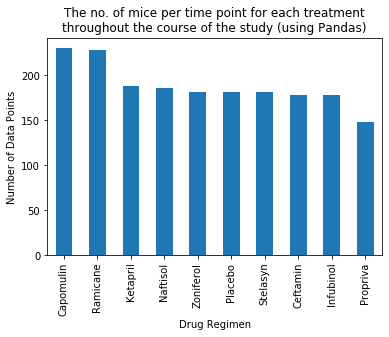

In [14]:
# Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pandas.
drug_regimen_vs_datapoint_data = cleansed_trial_data[['Drug Regimen']].copy()

sorted = drug_regimen_vs_datapoint_data['Drug Regimen'].value_counts().to_frame().reset_index().rename(columns={'index':'Drug Regimen', 'Drug Regimen':'Count'})

pandas_chart = sorted.plot.bar(x='Drug Regimen', y='Count', rot=90, legend = None)
pandas_chart.set_ylabel("Number of Data Points")
pandas_chart.set_title("The no. of mice per time point for each treatment\nthroughout the course of the study (using Pandas)")
plt.savefig("../Images/no_mice_per_time_point_pandas")
pandas_chart

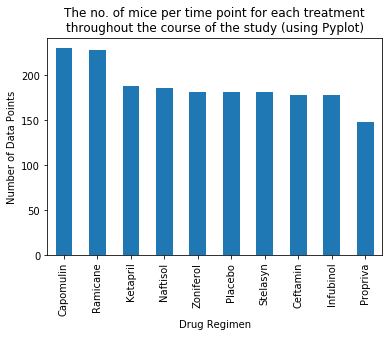

In [16]:
# Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pyplot.
drug_regimen_vs_datapoint = cleansed_trial_data[['Drug Regimen']].copy()
sorted = drug_regimen_vs_datapoint['Drug Regimen'].value_counts().to_frame().reset_index().rename(columns={'index':'Drug Regimen', 'Drug Regimen':'count'})

pyplot_chart = sorted.plot.bar(x='Drug Regimen', y='count', rot=90)

# Set the xlabel and ylabel using class methods
pyplot_chart.set_xlabel("Drug Regimen")
pyplot_chart.set_ylabel("Number of Data Points")
pyplot_chart.get_legend().remove()
pyplot_chart.set_title("The no. of mice per time point for each treatment\nthroughout the course of the study (using Pyplot)")
plt.savefig("../Images/no_mice_per_time_point_pyplot")
plt.show()

## Pie Plots

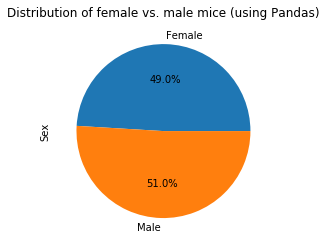

In [17]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

mouse_sex = cleansed_trial_data.groupby("Sex")

gender_group_count = pd.DataFrame(mouse_sex["Sex"].count())


gender_group_count.plot(kind='pie', y='Sex',autopct='%1.1f%%',legend=False,)
plt.title("Distribution of female vs. male mice (using Pandas)")
plt.savefig("../Images/distribution_m_vs_f_pandas_pandas")
plt.show(block=False)

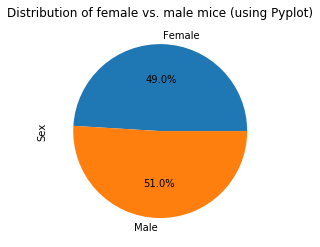

In [20]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
chart_labels = list(gender_group_count.index.values)

plyplot_data = gender_group_count["Sex"]

plt.pie(plyplot_data, labels=chart_labels, autopct='%1.1f%%')
plt.title("Distribution of female vs. male mice (using Pyplot)")
plt.ylabel('Sex', rotation=90)
plt.savefig("../Images/distribution_m_vs_f_pandas_pyplot")
plt.show(block=False)

## Quartiles, Outliers and Boxplots

In [21]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers. 

# Creating based on drugs in README.md, that we know are the most 'promising'
drug_list = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# taking 'drug_list as an arguement, to ensure only the most promising drugs are kept.
drugs_trial_data = cleansed_trial_data[cleansed_trial_data['Drug Regimen'].isin(drug_list)]

# sanity check entire Dataframe
drugs_trial_data.to_csv("data/sanity/drugs_trial_data.csv", index="false")

# previewing new dataframe subset
drugs_trial_data.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,b128,5,45.7,0,Capomulin,Female,9,22
2,b128,10,43.3,0,Capomulin,Female,9,22
3,b128,15,43.8,0,Capomulin,Female,9,22
4,b128,20,42.7,0,Capomulin,Female,9,22


In [22]:
# Grouping by 'Mouse ID', before 
last_tumor_marker_subset = drugs_trial_data.groupby(['Drug Regimen','Mouse ID']).agg(\
                                                                                     last_tumor_marker=('Tumor Volume (mm3)',lambda x: x.iloc[-1])).round(2)
# sanity check on subset
last_tumor_marker_subset.to_csv("data/sanity/last_tumor_marker_subset.csv", index="false")

# previewing output
last_tumor_marker_subset.head()

last_tumor_marker
Drug Regimen Mouse ID                   
Capomulin    b128                   39.0
             b742                   38.9
             f966                   30.5
             g288                   37.1
             g316                   40.2

In [23]:
# Using the stack funtion to set the Drug Regimen values as the headers. Also setting the Mouse ID as the index. Finally filling in NaN values with zeros, to avoid ambiguity 
ltm_stacking = four_last_tumor_unstack = last_tumor_marker_subset.stack(level=0).unstack(level=0)
ltm_stacking.head()

,Drug Regimen,Capomulin,Ceftamin,Infubinol,Ramicane
Mouse ID,,,,,
a203,last_tumor_marker,NaN,NaN,68.0,NaN
a251,last_tumor_marker,NaN,NaN,65.5,NaN
a275,last_tumor_marker,NaN,63.0,NaN,NaN
a411,last_tumor_marker,NaN,NaN,NaN,38.4
a444,last_tumor_marker,NaN,NaN,NaN,43.0


In [24]:
# for loop, to iterate through all 4 drugs in my drug_list and run the following calculations
for drug in drug_list:
    
# Calculation methodology.
    quartiles = ltm_stacking[drug].quantile([.25,.5,.75]).round(2)
    lower_quart = quartiles[0.25].round(2)
    upper_quart = quartiles[0.75].round(2)
    iqr = round(upper_quart - lower_quart,2)
    low_bound = round(lower_quart - (1.5*iqr),2)
    up_bound = round (upper_quart + (1.5*iqr),2)
    
    print(f"\033[1m{drug} IQR data is: \033[0m")
    print(f"Lower Quartile: {lower_quart}")
    print(f"Upper Quartile: {upper_quart}")
    print(f"Interquartile Range: {iqr}")
    print(f"Median: {quartiles[0.5]} ")
    print(f"Values less than {low_bound} are potential outliers.")
    print(f"Values greater than {up_bound} are potential outliers.\n--------------------------------------------------------")

Capomulin IQR data is: 
Lower Quartile: 32.4
Upper Quartile: 40.2
Interquartile Range: 7.8
Median: 38.1 
Values less than 20.7 are potential outliers.
Values greater than 51.9 are potential outliers.
--------------------------------------------------------
Ramicane IQR data is: 
Lower Quartile: 31.6
Upper Quartile: 40.7
Interquartile Range: 9.1
Median: 36.6 
Values less than 17.95 are potential outliers.
Values greater than 54.35 are potential outliers.
--------------------------------------------------------
Infubinol IQR data is: 
Lower Quartile: 54.0
Upper Quartile: 65.5
Interquartile Range: 11.5
Median: 60.2 
Values less than 36.75 are potential outliers.
Values greater than 82.75 are potential outliers.
--------------------------------------------------------
Ceftamin IQR data is: 
Lower Quartile: 48.7
Upper Quartile: 64.3
Interquartile Range: 15.6
Median: 59.9 
Values less than 25.3 are potential outliers.
Values greater than 87.7 are potential outliers.
-------------------------

In [25]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

# I will use this to store the values, returned from the for loop, that will iterate through my drug_list, created earlier.
boxplot_data = []

for drug in drug_list:
    boxplot_data.append(list(ltm_stacking[drug].dropna()))

<function matplotlib.pyplot.show(*args, **kw)>

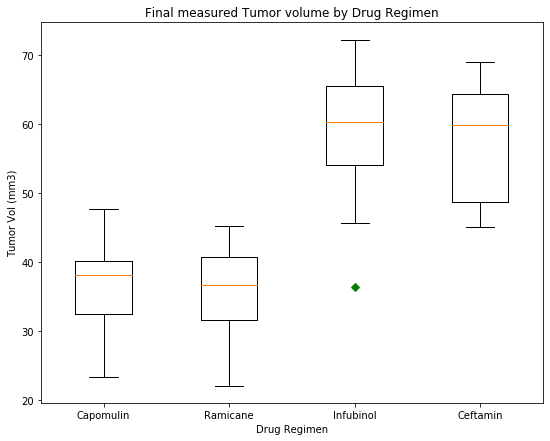

In [26]:
boxplot_chart, ax = plt.subplots(figsize=(9,7))
ax.set_title('Final measured Tumor volume by Drug Regimen')
ax.set_xlabel('Drug Regimen')
ax.set_ylabel('Tumor Vol (mm3)')
ax.boxplot(boxplot_data,notch=0,sym='gD')
plt.xticks([1,2,3,4],drug_list)
plt.savefig("../Images/box_plot_final_tumor_volume")
plt.show

## Line and Scatter Plots

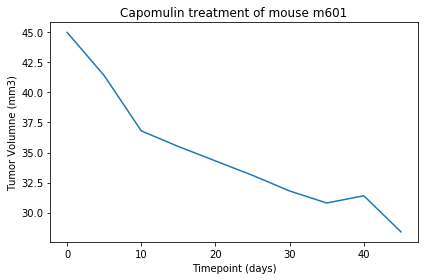

In [27]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin.

# I have chosen 'm601' because of it's adorable name!
capomulin_regimen = trial_data.loc[trial_data["Mouse ID"] == 'm601']

m601 = capomulin_regimen.drop(columns=["Mouse ID", "Metastatic Sites", "Sex", "Age_months", "Weight (g)"])

# m601.plot(x="Timepoint", y="Tumor Volume (mm3)")
# plt.show()
m601_chart = m601.plot.line(x='Timepoint', y='Tumor Volume (mm3)')

# Set the xlabel and ylabel using class methods
m601_chart.set_title("Capomulin treatment of mouse m601")
m601_chart.set_xlabel("Timepoint (days)")
m601_chart.set_ylabel("Tumor Volumne (mm3)")
m601_chart.get_legend().remove()
plt.tight_layout()
plt.savefig("../Images/capomulin_treatment_m601")
plt.show()

In [94]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
campomulin_data = trial_data.loc[trial_data["Drug Regimen"] == 'Capomulin']

capomulin = campomulin_data.groupby(['Mouse ID']).agg(\
        Mouse_weight=('Weight (g)', np.mean),\
        Tumor_vol_mean=('Tumor Volume (mm3)', np.mean)\
).round(2)
capomulin.head(30)


,Mouse_weight,Tumor_vol_mean
Mouse ID,,
b128,22,41.98
b742,21,40.08
f966,17,36.50
g288,19,42.01
g316,22,44.61
i557,24,44.81
i738,20,39.14
j119,23,44.46
j246,21,43.21


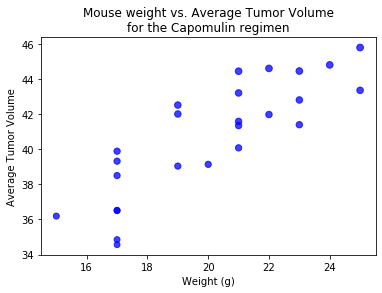

In [95]:
plt.scatter(
    capomulin['Mouse_weight'],
    capomulin['Tumor_vol_mean'],
    marker='o',
    facecolors='blue',
    s=capomulin['Tumor_vol_mean'],
    alpha=.75)

plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume")
plt.title("Mouse weight vs. Average Tumor Volume\nfor the Capomulin regimen")
plt.show()

## Correlation and Regression

Text(0, 0.5, 'Tumor Volume (mm3)')

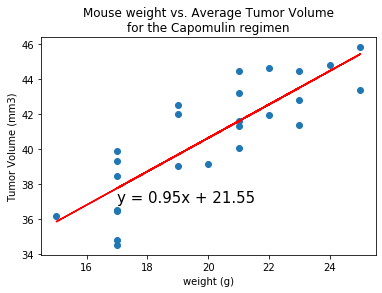

In [96]:
x_values = capomulin['Mouse_weight']
y_values = capomulin['Tumor_vol_mean']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = f'y = {str(round(slope,2))}x + {str(round(intercept,2))}'

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(17,37),fontsize=15,color="black")

plt.title("Mouse weight vs. Average Tumor Volume\nfor the Capomulin regimen")
plt.xlabel("weight (g)")
plt.ylabel("Tumor Volume (mm3)")

In [97]:
# Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen
correlation = st.pearsonr(capomulin['Mouse_weight'],capomulin['Tumor_vol_mean'])
print(f"The correlation between mouse weight and average tumor volume is {round(correlation[0],2)}")

The correlation between mouse weight and average tumor volume is 0.84
